# **Temperature Prediction**

program ini berfungsi untuk memprediksi temperatur suatu daerah berdasarkan tanggal

# **Get Data**

Kode dibawah mengambil data temperatur Kota Riga tahun 2015 - 2020

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/city_temperature.csv')
df = df.loc[df["City"] == "Riga"]
df = df.loc[df["Year"] > 2014]

df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
820322,Europe,Latvia,NaN,Riga,1,1,2015,38.6
820323,Europe,Latvia,NaN,Riga,1,2,2015,40.3
820324,Europe,Latvia,NaN,Riga,1,3,2015,39.4
820325,Europe,Latvia,NaN,Riga,1,4,2015,34.9
820326,Europe,Latvia,NaN,Riga,1,5,2015,26.4
...,...,...,...,...,...,...,...,...
822278,Europe,Latvia,NaN,Riga,5,9,2020,50.1
822279,Europe,Latvia,NaN,Riga,5,10,2020,55.7
822280,Europe,Latvia,NaN,Riga,5,11,2020,45.3
822281,Europe,Latvia,NaN,Riga,5,12,2020,41.7


tambah index baru

In [ ]:
index = []
for i in range(len(df['Day'])):
    index.append(i)

df_new = pd.DataFrame({'hari': index,
                   'suhu': df['AvgTemperature']})

memisahkan data menjadi train dan validation

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(df_new['suhu'], 
                                                      df_new['hari'], 
                                                      test_size = 0.2, 
                                                      shuffle = False )
print(len(x_train), len(x_valid))

1568 393


menampilkan bentuk data

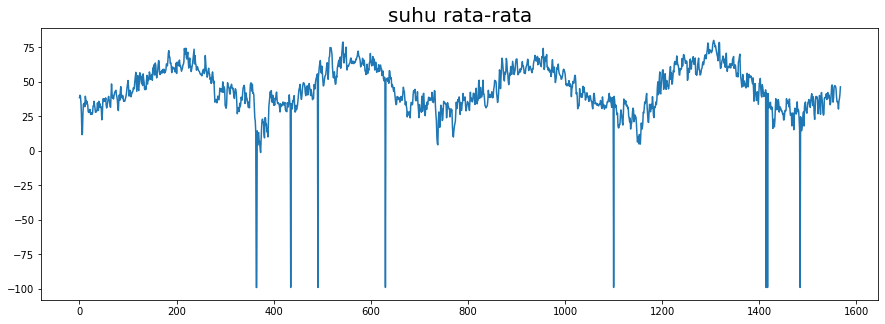

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_train, x_train)
plt.title('suhu rata-rata',
          fontsize=20);

# **Membuat window**

In [ ]:

import numpy as np
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

transformasi data agar dapat dimasukan ke model

In [ ]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

# **membuat model**

In [ ]:
from keras.layers import Dense, LSTM

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

fungsi batas nilai 10% MAE untuk callback

In [ ]:
Mae = (df_new['suhu'].max() - df_new['suhu'].min()) * 10/100
print(Mae)

17.91


fungsi callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<Mae and logs.get('val_mae')<Mae):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

# **train model**

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=100,
                    validation_data = val_set, 
                    callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


8/8 [==============================] - 7s 399ms/step - loss: 45.8804 - mae: 46.3804 - val_loss: 46.5872 - val_mae: 47.0872
Epoch 2/100
8/8 [==============================] - 2s 220ms/step - loss: 45.7398 - mae: 46.2398 - val_loss: 46.3936 - val_mae: 46.8936
Epoch 3/100
8/8 [==============================] - 2s 222ms/step - loss: 45.5469 - mae: 46.0469 - val_loss: 46.2245 - val_mae: 46.7245
Epoch 4/100
8/8 [==============================] - 2s 225ms/step - loss: 45.4355 - mae: 45.9355 - val_loss: 46.1679 - val_mae: 46.6679
Epoch 5/100
8/8 [==============================] - 2s 216ms/step - loss: 45.3869 - mae: 45.8869 - val_loss: 46.1168 - val_mae: 46.6168
Epoch 6/100
8/8 [==============================] - 2s 217ms/step - loss: 45.3376 - mae: 45.8376 - val_loss: 46.0636 - val_mae: 46.5636
Epoch 7/100
8/8 [==============================] - 2s 217ms/step - loss: 45.2853 - mae: 45.7853 - val_loss: 46.0087 - val_mae: 46.5087
Epoch 8/100
8/8 [==============================] - 2s 222ms/step - 

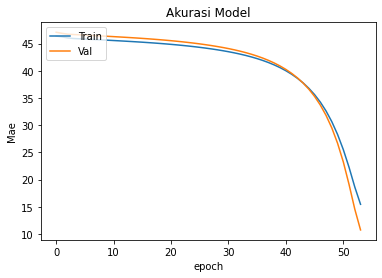

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


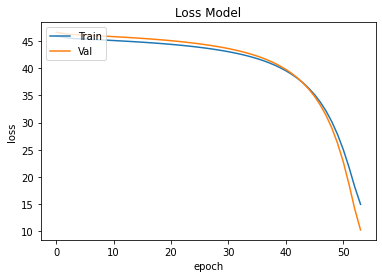

In [ ]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()